In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, ShuffleSplit

Add image here

# Data Loading Tools

Steps 1 and 2

Lulu: make_time_windows and make_x_y is similar to Aisha's data_label_split and data_divide. Differences:
* make_x_y requires a single column to be selected and builds y's from it
* make_time_windows fixes the sequence length and drags the window down each participant's timeseries (not the concatenated npy with all visits)

To do:
* Normalisation/Scaling

In [10]:
def load_DoppelGANger():
  ori_data = pd.read_csv('/content/cat_time_5abovevisits_all.csv') # max timeseries length = 130
  # gen_data = pd.read_csv('/content/gen_doptf2_cat_5abovevisits_e100_lstm.csv') # max timeseries length = 107
  gen_data = pd.read_csv('/content/gen_doptf2_cat_5abovevisits_e200_lstm.csv') # max timeseries length = 111
  ori_data = ori_data.drop(columns=['diar_No', 'diar_Yes', 'head_No', 'head_Yes'])
  gen_data = gen_data.drop(columns=['diar_No', 'diar_Yes', 'head_No', 'head_Yes'])
  ori_data = cat_df_to_3d_array(ori_data, 130) # array (1347, 130, 10)
  gen_data = cat_df_to_3d_array(gen_data, 130) # array (1347, 130, 10)
  return ori_data, gen_data 

def cat_df_to_3d_array(data, max_length):
  data.fillna(0)
  # max_length = data['id'].value_counts().max() # if you want to get it from the data, but ori/gen may have different max lengths
  lst = []
  for i in data.id.unique():
    timeseries = data[data['id']==i].drop(columns='id').to_numpy()
    length, _ = np.shape(timeseries)
    timeseries = np.pad(timeseries, pad_width=((0,max_length-length), (0,0)), mode='constant') # fill remaining rows with zeros
    lst.append(timeseries)
  array = np.stack(lst)
  return array


def make_time_windows(dataset, w):
  """replaces each participant's 130 long timeseries with all their w length window timeseries
  """
  num_participants, full_length, _ = np.shape(dataset)
  time_windows = []

  for i in list(range(num_participants)): # i = participant's position in dataset

    for j in list(range(full_length-w+1)): # j = row number of first row in window
      time_windows.append(dataset[i,j:j+w,:])

  return np.stack(time_windows)


def make_x_y(dataset, y_index, w):
  """make inputs for model. Note the returned data's sequence length = w-1
    Choose w less than time window length!
  """
  dataset = make_time_windows(dataset, w)
  x = np.delete(dataset, obj=y_index, axis=2) # remove y column from all time series
  x = np.delete(x, obj=-1, axis=1) # remove last row from all time series
  y = dataset[:,1:,[y_index]] # take only y column and remove its earliest cell
  return x, y

Shape Checks:

In [3]:
data = pd.read_csv('/content/gen_doptf2_cat_5abovevisits_e200_lstm.csv')
data['id'].value_counts().max()

111

In [11]:
ori_set, gen_set = load_DoppelGANger()
print([np.shape(_set) for _set in [ori_set, gen_set]])

x, y = make_x_y(ori_set, 0, 129)
print([np.shape(_set) for _set in [x, y]])
print([type(_set) for _set in [x, y]])

[(1347, 130, 6), (1347, 130, 6)]
[(2694, 128, 5), (2694, 128, 1)]
[<class 'numpy.ndarray'>, <class 'numpy.ndarray'>]


In [7]:
gen_set[0]

array([[2.87951003e+01, 1.05582377e+02, 2.12656174e+01, ...,
        2.68436465e-02, 9.66183603e-01, 3.38163525e-02],
       [2.61913285e+01, 1.13313898e+02, 1.95270626e+01, ...,
        4.74381968e-02, 7.71803737e-01, 2.28196263e-01],
       [2.58570886e+01, 1.20022170e+02, 2.29951503e+01, ...,
        1.56752869e-01, 8.60333860e-01, 1.39666155e-01],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

# Define Predictive Model

Lulu: moved import statements out of functions and to the top of the document

In [17]:
def last_time_step_mae(Y_true, Y_pred):
  return tf.keras.metrics.MAE(Y_true[:, -1], Y_pred[:, -1])

def make_predictive_model(num_cols):
  input_size = [None,num_cols-1] #
  hidden_dim = num_cols//2 #

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=input_size)) # shape = [#timesteps -1, #features=dim-1] per 
  model.add(tf.keras.layers.GRU(hidden_dim, return_sequences=True)) # shape = [#timesteps -1, hidden_dim]
  model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(hidden_dim, activation = "sigmoid")))  # shape = [#timesteps -1, hidden_dim]
  model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation = "linear")))  # output shape = [#timesteps -1, 1]

  model.compile(optimizer = "adam", loss = tf.keras.losses.MeanAbsoluteError(), metrics=[last_time_step_mae])

  return model

# Define Evaluation Scheme

Lulu to do: 
* change args to list//tuple//dict type for easier looping through sets of prameters
* is loss working right? seems proportional to window length. Must normalise beforehand?

In [ ]:
def predictive_train_test(train_set, test_set, y_cols='all', windows='max', val_ratio=0.2, batch_size=64, epochs=15, show_training=True):
  """ does the T_T_ portion of the scheme

  Args:
    - train_set, test_set: ori_data, gen_data in order of T_T_ (labels NOT yet split off)
      Make sure train and test are disjoint!
      If doing TSTSvsTRTR then use this function twice
    - y_cols: list of columns to use as target
    - windows: list contains lengths of windows to be used in order of y columns
              NOTE length of input sequences is actually window_length - 1 because of make_x_y
    - val_ratio: validation set ratio split from train_set for use during training
    - batch_size
    - epochs

  Returns:
   - results:
   """



  results = []
  histories = []
  _, max_window, num_columns = np.shape(train_set)
  
  #### for convenience when not tuning parameters
  if y_cols=='all':
    y_cols = list(range(num_columns))

  if windows=='max':
    windows=[max_window]*len(y_cols)
  elif isinstance(windows, int):
      windows=[windows]*len(y_cols)

  for k in range(len(y_cols)): # step 5 (repeating steps 2-4 for each column)
    print('\nPredictive model running for column ', str(y_cols[k]), ' with window length ', str(windows[k]))
    train_x, train_y = make_x_y(train_set, y_cols[k], windows[k]) # step 2
    test_x, test_y = make_x_y(test_set, y_cols[k], windows[k])
    train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=val_ratio)

    model = make_predictive_model(num_columns)
    hist = model.fit(np.asarray(train_x), np.asarray(train_y), batch_size=batch_size, epochs=epochs, validation_data=(val_x, val_y)) # step 4
    print('Getting results for column ', str(y_cols[k]), ' with window length ', str(windows[k]))

    results.append([y_cols[k], windows[k], batch_size, epochs]+model.evaluate(test_x, test_y, batch_size=batch_size))
    histories.append(hist)

    if show_training:
      plt.plot(hist.history['loss'])
      plt.plot(hist.history['val_loss'])
      plt.title('model loss')
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.legend(['train loss', 'val loss'], loc='upper right')
      plt.show()

  results_df = pd.DataFrame(results, columns=['y_col', 'window_length', 'batch_size', 'epochs', 'test_loss', 'test_metric'])

  return results_df, histories

# TRTS Example

In [16]:
TRTS_results, TRTS_histories = predictive_train_test(ori_set, gen_set, windows=[65,65,65,65,65, 65])


Predictive model running for column  0  with window length  65
Epoch 1/15
 254/1112 [=====>........................] - ETA: 9s - loss: nan - last_time_step_mae: nan

KeyboardInterrupt: ignored

In [ ]:
TRTS_results

,y_col,window_length,batch_size,epochs,test_loss,test_metric
0,0,65,64,15,6.726365,1.083900
1,1,65,64,15,4.044926,0.509953
2,2,65,64,15,20.597420,2.934123
3,3,65,64,15,1.434082,0.178937
4,4,65,64,15,4.037988,0.608182


In [ ]:
TRTS_results.to_csv('dp_predictive_trts_results.csv', index=False)

# TSTR Example


Predictive model running for column  0  with window length  65
Epoch 1/15
1112/1112 [==============================] - 7s 7ms/step - loss: 7.9275 - last_time_step_mae: 1.3213 - val_loss: 7.7680 - val_last_time_step_mae: 1.2843
Epoch 2/15
1112/1112 [==============================] - 7s 6ms/step - loss: 7.7561 - last_time_step_mae: 1.2350 - val_loss: 7.6263 - val_last_time_step_mae: 1.2634
Epoch 3/15
1112/1112 [==============================] - 7s 7ms/step - loss: 7.5954 - last_time_step_mae: 1.2104 - val_loss: 7.4578 - val_last_time_step_mae: 1.2373
Epoch 4/15
1112/1112 [==============================] - 7s 6ms/step - loss: 7.4194 - last_time_step_mae: 1.1828 - val_loss: 7.2855 - val_last_time_step_mae: 1.2108
Epoch 5/15
1112/1112 [==============================] - 7s 6ms/step - loss: 7.2456 - last_time_step_mae: 1.1564 - val_loss: 7.1209 - val_last_time_step_mae: 1.1851
Epoch 6/15
1112/1112 [==============================] - 7s 6ms/step - loss: 7.0835 - last_time_step_mae: 1.1308 - va

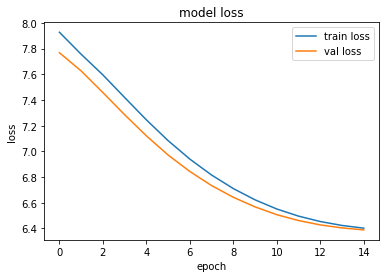


Predictive model running for column  1  with window length  65
Epoch 1/15
1112/1112 [==============================] - 7s 7ms/step - loss: 6.3096 - last_time_step_mae: 0.8332 - val_loss: 6.2755 - val_last_time_step_mae: 0.8600
Epoch 2/15
1112/1112 [==============================] - 7s 7ms/step - loss: 6.1712 - last_time_step_mae: 0.8031 - val_loss: 6.1252 - val_last_time_step_mae: 0.8393
Epoch 3/15
1112/1112 [==============================] - 8s 7ms/step - loss: 6.0043 - last_time_step_mae: 0.7789 - val_loss: 5.9528 - val_last_time_step_mae: 0.8147
Epoch 4/15
1112/1112 [==============================] - 7s 7ms/step - loss: 5.8209 - last_time_step_mae: 0.7522 - val_loss: 5.7563 - val_last_time_step_mae: 0.7861
Epoch 5/15
1112/1112 [==============================] - 7s 6ms/step - loss: 5.6155 - last_time_step_mae: 0.7222 - val_loss: 5.5424 - val_last_time_step_mae: 0.7561
Epoch 6/15
1112/1112 [==============================] - 7s 6ms/step - loss: 5.4053 - last_time_step_mae: 0.6919 - va

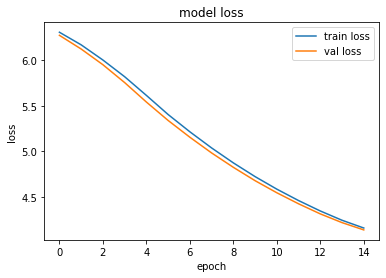


Predictive model running for column  2  with window length  65
Epoch 1/15
1112/1112 [==============================] - 7s 6ms/step - loss: 23.4587 - last_time_step_mae: 3.3648 - val_loss: 22.9405 - val_last_time_step_mae: 3.3463
Epoch 2/15
1112/1112 [==============================] - 7s 6ms/step - loss: 23.3537 - last_time_step_mae: 3.3240 - val_loss: 22.8267 - val_last_time_step_mae: 3.3290
Epoch 3/15
1112/1112 [==============================] - 7s 6ms/step - loss: 23.2107 - last_time_step_mae: 3.3034 - val_loss: 22.6625 - val_last_time_step_mae: 3.3043
Epoch 4/15
1112/1112 [==============================] - 7s 6ms/step - loss: 23.0255 - last_time_step_mae: 3.2765 - val_loss: 22.4633 - val_last_time_step_mae: 3.2744
Epoch 5/15
1112/1112 [==============================] - 7s 6ms/step - loss: 22.8136 - last_time_step_mae: 3.2458 - val_loss: 22.2460 - val_last_time_step_mae: 3.2417
Epoch 6/15
1112/1112 [==============================] - 7s 6ms/step - loss: 22.5895 - last_time_step_mae: 

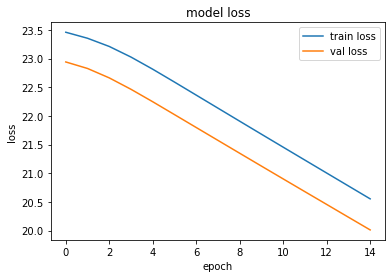


Predictive model running for column  3  with window length  65
Epoch 1/15
1112/1112 [==============================] - 8s 7ms/step - loss: 2.0730 - last_time_step_mae: 0.2925 - val_loss: 2.0870 - val_last_time_step_mae: 0.2636
Epoch 2/15
1112/1112 [==============================] - 7s 7ms/step - loss: 1.9502 - last_time_step_mae: 0.2421 - val_loss: 1.9570 - val_last_time_step_mae: 0.2458
Epoch 3/15
1112/1112 [==============================] - 7s 7ms/step - loss: 1.8232 - last_time_step_mae: 0.2236 - val_loss: 1.8300 - val_last_time_step_mae: 0.2297
Epoch 4/15
1112/1112 [==============================] - 7s 7ms/step - loss: 1.7028 - last_time_step_mae: 0.2067 - val_loss: 1.7124 - val_last_time_step_mae: 0.2136
Epoch 5/15
1112/1112 [==============================] - 7s 7ms/step - loss: 1.5996 - last_time_step_mae: 0.1914 - val_loss: 1.6193 - val_last_time_step_mae: 0.2024
Epoch 6/15
1112/1112 [==============================] - 7s 6ms/step - loss: 1.5172 - last_time_step_mae: 0.1809 - va

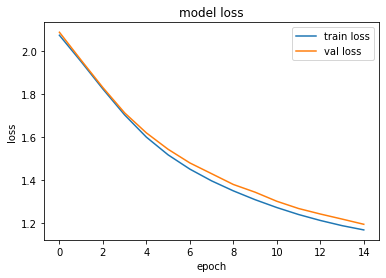


Predictive model running for column  4  with window length  65
Epoch 1/15
1112/1112 [==============================] - 7s 6ms/step - loss: 7.1488 - last_time_step_mae: 1.1634 - val_loss: 6.8464 - val_last_time_step_mae: 1.0479
Epoch 2/15
1112/1112 [==============================] - 7s 6ms/step - loss: 6.9838 - last_time_step_mae: 1.0297 - val_loss: 6.8029 - val_last_time_step_mae: 1.0413
Epoch 3/15
1112/1112 [==============================] - 7s 6ms/step - loss: 6.9420 - last_time_step_mae: 1.0239 - val_loss: 6.7634 - val_last_time_step_mae: 1.0351
Epoch 4/15
1112/1112 [==============================] - 7s 6ms/step - loss: 6.9024 - last_time_step_mae: 1.0182 - val_loss: 6.7259 - val_last_time_step_mae: 1.0301
Epoch 5/15
1112/1112 [==============================] - 7s 6ms/step - loss: 6.8637 - last_time_step_mae: 1.0125 - val_loss: 6.6884 - val_last_time_step_mae: 1.0245
Epoch 6/15
1112/1112 [==============================] - 7s 6ms/step - loss: 6.8251 - last_time_step_mae: 1.0069 - va

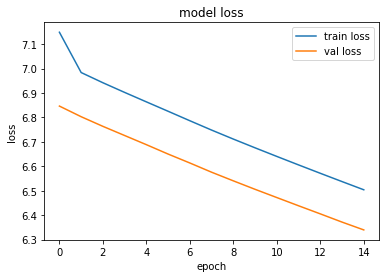

In [ ]:
TSTR_results, TSTR_histories = predictive_train_test(gen_set, ori_set, windows=[65,65,65,65,65])

In [ ]:
TSTR_results

,y_col,window_length,batch_size,epochs,test_loss,test_metric
0,0,65,64,15,4.548269,0.580051
1,1,65,64,15,2.580028,0.356853
2,2,65,64,15,20.981253,3.535945
3,3,65,64,15,1.542471,0.203011
4,4,65,64,15,6.689484,1.108748


In [ ]:
TSTR_results.to_csv('dp_predictive_tstr_results.csv', index=False)

# TRTR vs TSTS Example


Predictive model running for column  0  with window length  130
Epoch 1/20
9/9 [==============================] - 1s 66ms/step - loss: nan - last_time_step_mae: nan - val_loss: nan - val_last_time_step_mae: nan
Epoch 2/20
9/9 [==============================] - 0s 22ms/step - loss: nan - last_time_step_mae: nan - val_loss: nan - val_last_time_step_mae: nan
Epoch 3/20
9/9 [==============================] - 0s 22ms/step - loss: nan - last_time_step_mae: nan - val_loss: nan - val_last_time_step_mae: nan
Epoch 4/20
9/9 [==============================] - 0s 23ms/step - loss: nan - last_time_step_mae: nan - val_loss: nan - val_last_time_step_mae: nan
Epoch 5/20
9/9 [==============================] - 0s 22ms/step - loss: nan - last_time_step_mae: nan - val_loss: nan - val_last_time_step_mae: nan
Epoch 6/20
9/9 [==============================] - 0s 22ms/step - loss: nan - last_time_step_mae: nan - val_loss: nan - val_last_time_step_mae: nan
Epoch 7/20
9/9 [==============================] - 0s 

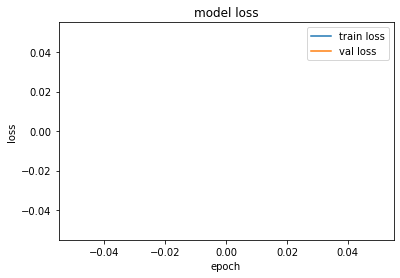


Predictive model running for column  1  with window length  130
Epoch 1/20
9/9 [==============================] - 1s 66ms/step - loss: nan - last_time_step_mae: nan - val_loss: nan - val_last_time_step_mae: nan
Epoch 2/20
9/9 [==============================] - 0s 21ms/step - loss: nan - last_time_step_mae: nan - val_loss: nan - val_last_time_step_mae: nan
Epoch 3/20
9/9 [==============================] - 0s 21ms/step - loss: nan - last_time_step_mae: nan - val_loss: nan - val_last_time_step_mae: nan
Epoch 4/20
9/9 [==============================] - 0s 21ms/step - loss: nan - last_time_step_mae: nan - val_loss: nan - val_last_time_step_mae: nan
Epoch 5/20
9/9 [==============================] - 0s 21ms/step - loss: nan - last_time_step_mae: nan - val_loss: nan - val_last_time_step_mae: nan
Epoch 6/20
9/9 [==============================] - 0s 22ms/step - loss: nan - last_time_step_mae: nan - val_loss: nan - val_last_time_step_mae: nan
Epoch 7/20
9/9 [==============================] - 0s 

KeyboardInterrupt: ignored

In [18]:
train_ori_set, test_ori_set = train_test_split(ori_set, train_size=0.5)
TRTR_results, TRTR_histories = predictive_train_test(train_ori_set, test_ori_set, windows=130, epochs=20)

train_gen_set, test_gen_set = train_test_split(gen_set, train_size=0.5)
TSTS_results, TSTS_histories = predictive_train_test(train_gen_set, test_gen_set, windows=130, epochs=20)

In [ ]:
TRTR_results

,y_col,window_length,batch_size,epochs,test_loss,test_metric
0,0,65,64,20,5.357162,0.711760
1,1,65,64,20,3.354212,0.558199
2,2,65,64,20,20.354578,3.518324
3,3,65,64,20,1.838769,0.246920
4,4,65,64,20,6.998713,1.168536


In [ ]:
TRTR_results.to_csv('dp_predictive_trtr_results0827.csv', index=False)

In [ ]:
TSTS_results

,y_col,window_length,batch_size,epochs,test_loss,test_metric
0,0,65,64,20,7.385734,1.044242
1,1,65,64,20,4.519409,0.513693
2,2,65,64,20,18.541113,2.581589
3,3,65,64,20,1.559514,0.181012
4,4,65,64,20,4.623684,0.694531


In [ ]:
TSTS_results.to_csv('dp_predictive_tsts_results0827.csv', index=False)

### Comparing TRTR vs TSTS results

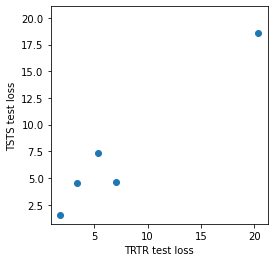

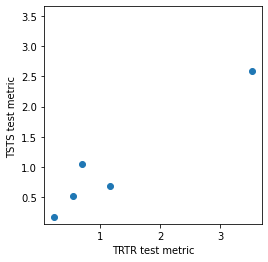

In [ ]:
plt.scatter(TRTR_results['test_loss'], TSTS_results['test_loss'])
plt.xlabel('TRTR test loss')
plt.ylabel('TSTS test loss')
plt.axis('square')
plt.show()

plt.scatter(TRTR_results['test_metric'], TSTS_results['test_metric'])
plt.xlabel('TRTR test metric')
plt.ylabel('TSTS test metric ')
plt.axis('square')
plt.show()

### SRA